# GAN Inversion via Latent Regression

## 1. Definition

**GAN inversion via latent regression** is a technique used to recover or infer the latent code $z$ that generated a given image $x$ from a pretrained generator $G$.  
The goal is to find an encoder or regressor $E$ such that:

$ E(x) \approx z $  
and  
$ G(E(x)) \approx x $

This builds an approximate inverse mapping of the generator.

Given:

- Generator: $G : \mathcal{Z} \rightarrow \mathcal{X}$  
- Latent: $z \sim p(z)$  
- Generated image: $x = G(z)$  

GAN inversion via latent regression trains a model $E$ to recover $z$ **directly** from $x$.

---

## 2. Objective of Latent Regression

The idea is simple:

Given a latent $z$, generate an image $x = G(z)$, then train a regression model $E$ to minimize:

$ \mathcal{L}_{\text{LR}} = \mathbb{E}_{z \sim p(z)}\left[ \lVert E(G(z)) - z \rVert_2^2 \right] $

This is called **latent regression loss**, or **LR loss**.

The encoder $E$ learns the inverse function of $G$ on the image manifold.

---

## 3. Derivation of the Latent Regression Objective

### Step 1: Define forward model

A pretrained generator produces images:

$ x = G(z),\quad z \sim p(z) $

Since the true inverse $G^{-1}(x)$ does not exist analytically, we approximate it using a learnable encoder:

$ \hat z = E(x) $

Our objective is to make:

$ E(G(z)) \approx z $

---

### Step 2: Mean squared error between true and predicted latent

The natural objective for regression is:

$ \mathcal{L}(E) = \mathbb{E}_{z \sim p(z)}\left[ \lVert E(G(z)) - z \rVert_2^2 \right] $

This encourages:

- latent consistency  
- approximate invertibility  
- stable mapping from image space to latent space  

---

### Step 3: Incorporating image-space reconstruction

Sometimes, an additional reconstruction term is used:

$ \mathcal{L}_{\text{rec}} = \mathbb{E}_{z}\left[ \lVert G(E(G(z))) - G(z) \rVert_1 \right] $

Final combined loss:

$ \mathcal{L}_{\text{total}} = \mathcal{L}_{\text{LR}} + \lambda\,\mathcal{L}_{\text{rec}} $

This helps align both latent and image domains.

---

## 4. Why Latent Regression Works

Latent regression forces:

$ E \approx G^{-1} $

on the true generator manifold.  
Since $G$ is smooth and continuous on the latent space, $E$ can learn a stable inverse even though $G$ may not be perfectly invertible.

This results in:

- better inversion accuracy  
- better editing controls  
- more faithful reconstructions compared to pure optimization methods  

---

## 5. Summary

- GAN inversion seeks $z$ such that $G(z) \approx x$.  
- Latent regression trains an encoder $E$ directly on synthetic pairs $(G(z), z)$.  
- The core loss is:  
  $ \mathcal{L}_{\text{LR}} = \mathbb{E}_{z}\left[ \lVert E(G(z)) - z \rVert_2^2 \right] $  
- Optionally add reconstruction loss in image space.  
- Provides fast and reliable inversion of GAN-generated images.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.46MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.net(z).view(-1, 1, 28, 28)
        return img

G = Generator().to(device)


In [ ]:
optimizer_G = optim.Adam(G.parameters(), lr=2e-3)
criterion = nn.MSELoss()

for epoch in range(2):       # tiny training just for demo
    for batch, _ in loader:
        batch = batch.to(device)
        z = torch.randn(batch.size(0), 100).to(device)

        fake = G(z)
        loss = criterion(fake.mean(), batch.mean())  # match global stats

        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()

    print("Epoch:", epoch, "Loss:", loss.item())


Epoch: 0 Loss: 7.772822573315352e-05
Epoch: 1 Loss: 5.158029671292752e-05


In [ ]:
for p in G.parameters():
    p.requires_grad = False


In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, z_dim)
        )

    def forward(self, x):
        return self.net(x)

E = Encoder().to(device)


In [ ]:
optimizer_E = optim.Adam(E.parameters(), lr=1e-3)
recon_loss = nn.MSELoss()

for epoch in range(100):
    for batch, _ in loader:
        batch = batch.to(device)

        z_hat = E(batch)          # inferred latent
        recon = G(z_hat)          # reconstruction

        loss = recon_loss(recon, batch)

        optimizer_E.zero_grad()
        loss.backward()
        optimizer_E.step()

    print("Epoch:", epoch, "Recon loss:", loss.item())


Epoch: 0 Recon loss: 0.3367733955383301
Epoch: 1 Recon loss: 0.32260048389434814
Epoch: 2 Recon loss: 0.32592031359672546
Epoch: 3 Recon loss: 0.34798663854599
Epoch: 4 Recon loss: 0.3497125506401062
Epoch: 5 Recon loss: 0.34482303261756897
Epoch: 6 Recon loss: 0.34687793254852295
Epoch: 7 Recon loss: 0.3442874252796173
Epoch: 8 Recon loss: 0.3497540354728699
Epoch: 9 Recon loss: 0.34952881932258606
Epoch: 10 Recon loss: 0.33820855617523193
Epoch: 11 Recon loss: 0.34519943594932556
Epoch: 12 Recon loss: 0.3515276610851288
Epoch: 13 Recon loss: 0.3416779041290283
Epoch: 14 Recon loss: 0.3350532650947571
Epoch: 15 Recon loss: 0.3259678781032562
Epoch: 16 Recon loss: 0.33200040459632874
Epoch: 17 Recon loss: 0.3547794818878174
Epoch: 18 Recon loss: 0.3396182656288147
Epoch: 19 Recon loss: 0.3253808617591858
Epoch: 20 Recon loss: 0.31534913182258606
Epoch: 21 Recon loss: 0.33591803908348083
Epoch: 22 Recon loss: 0.3358663320541382
Epoch: 23 Recon loss: 0.3394031524658203
Epoch: 24 Recon lo

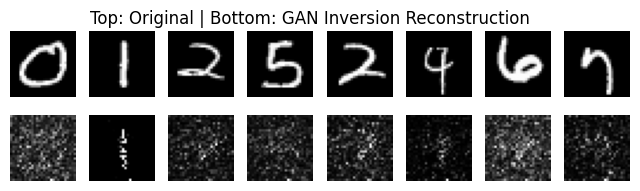

In [ ]:
import matplotlib.pyplot as plt

batch, _ = next(iter(loader))
batch = batch[:8].to(device)

with torch.no_grad():
    z_hat = E(batch)
    recon = G(z_hat)

batch = batch.cpu()
recon = recon.cpu()

plt.figure(figsize=(8,2))

for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(batch[i][0], cmap="gray")
    plt.axis("off")

    plt.subplot(2,8,8+i+1)
    plt.imshow(recon[i][0], cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: GAN Inversion Reconstruction")
plt.show()
